## Carregamento e preparo dos dados

In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import optuna

In [2]:
raw_data = pd.read_csv('yeast.data',
                       sep = '\s+',
                       header=None,
                       names=["Sequence Name","mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "label"]
                      )
raw_data.head()

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,label
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


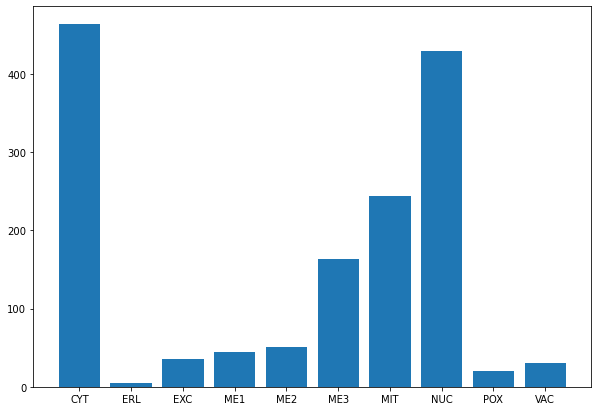

In [3]:
labels, count = np.unique(raw_data["label"], return_counts=True)
plt.figure(figsize=(10,7))
plt.bar(labels, count);

#### Descartando os atributos categóricos:

In [4]:
df = raw_data.drop(columns=["Sequence Name", "label"])
#df = df + 1
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


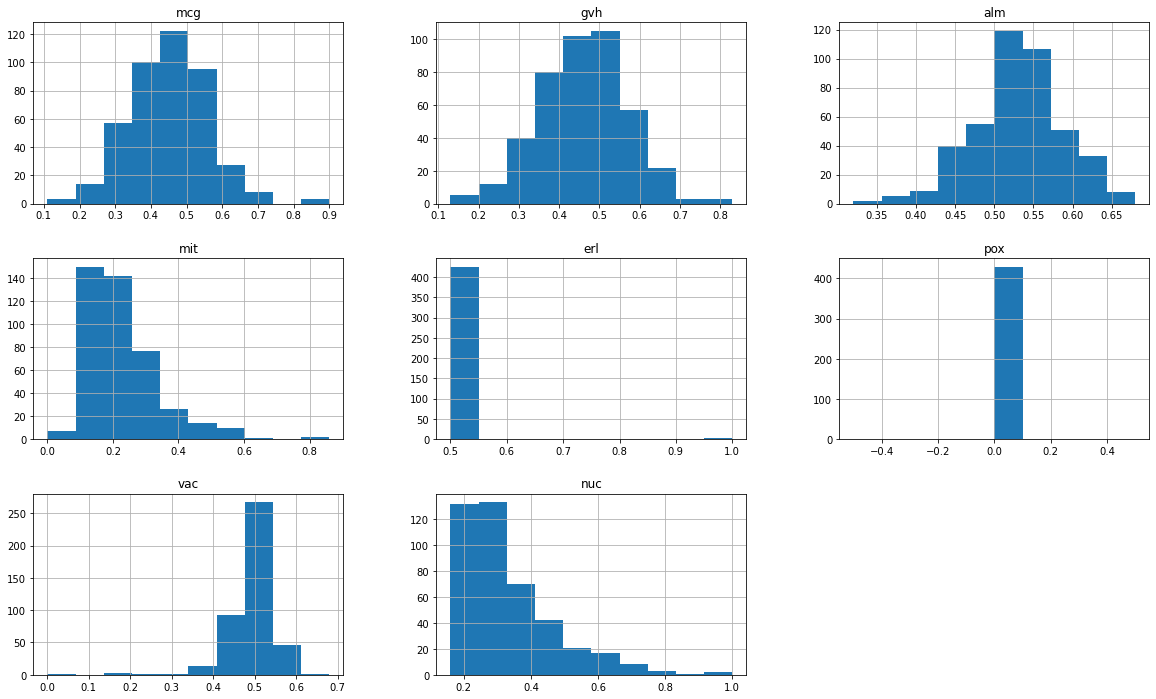

In [5]:
raw_data[raw_data["label"]== "NUC"].hist(figsize=(20,12));

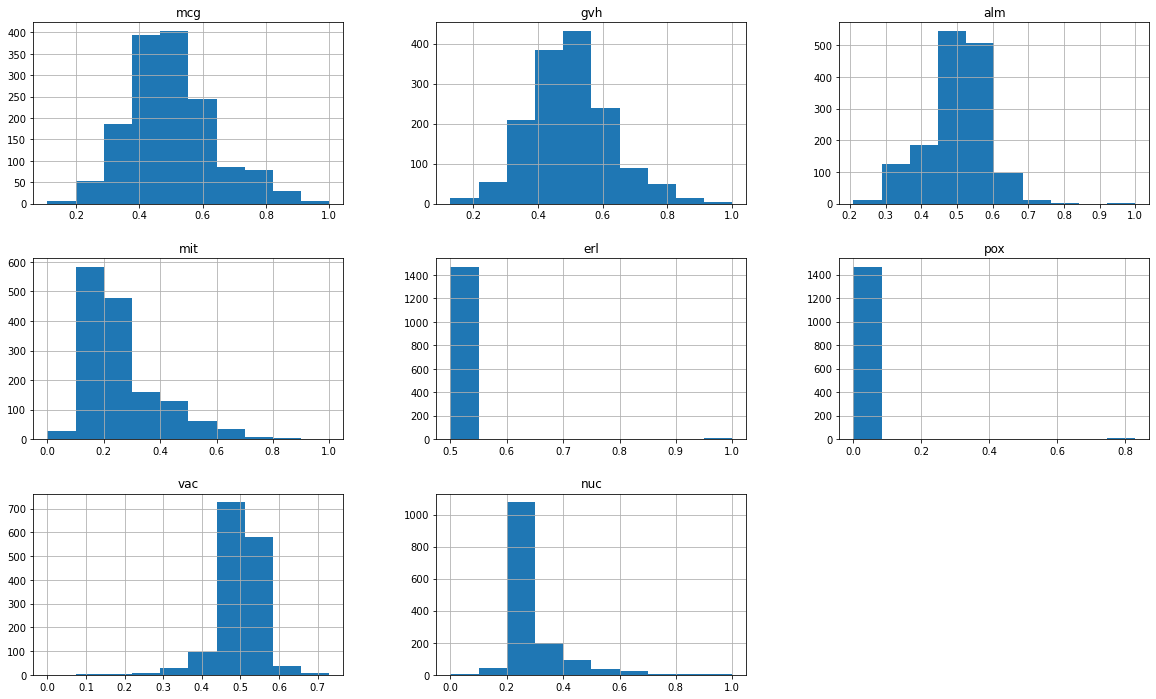

In [6]:
df.hist(figsize=(20,12));

In [7]:
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


## FCM-DFCV
#### A fuzzy clustering method based on an adaptive quadratic distance for each cluster defined by a diagonal fuzzy covariance matrix

#### Conceito:

É utilizado uma função softmax na inicialização aleatória de U, pois é ideal que a matriz U tenha  $\sum_{i=1}^{c} u_{ik} = 1$, ou seja, a soma dos graus de pertinência de uma amostra para todas as classe tem que ser 1.

In [8]:
3 * np.random.rand(2, 2)

array([[0.11220007, 1.01344304],
       [1.45460738, 0.38468886]])

In [9]:
softmax(3 * np.random.rand(2, 2), axis=0)

array([[0.29014045, 0.56353606],
       [0.70985955, 0.43646394]])

#### Classe do modelo:


In [10]:
class FCM_DFCV:
    def __init__(self, n_class, m, T, epsilon, rand_value_init_U, mim_distance=0.00001):
        self.n_class = n_class
        self.m = m
        self.T = T
        self.epsilon = epsilon
        self.mim_distance = mim_distance
        self.rand_value_init_U = rand_value_init_U
        
    def fit(self, df):
        
        self.n = df.shape[0]
        self.p = df.shape[1]

        for i in range(self.T):

            if i == 0:

               #Inicializacao da matriz de perminência aleatória
                U = self.init_U_random()
                #G_anterior interacao 0
                G = np.zeros([self.n_class, self.p])
                M = np.zeros([self.n_class, self.p, self.p])
                J = np.inf
                self.J_best = J

            else:
                #Calculo da matriz de pertinência
                U = self.calc_U(D_M)
                #break
                
            #Calculo dos prototipos    
            G = self.calc_G(df, U, G)
            #import pdb;pdb.set_trace()    

            M = self.calc_M(U, df, G, M)
            #Calculo das distâncias quadraticas
            D_M = self.calc_D_M(df, G, M)
            
            #Calculo da função de custo
            J_ant = J
            J = self.calc_J(U, D_M)
            #self.plot(G)
        
            if self.J_best > J :
                self.J_best = J
                self.U = U
                self.G = G
                
            if np.abs(J - J_ant) < self.epsilon:
                break
                
            
            #print(J)
            #break
#        import pdb;pdb.set_trace()   

    
    def plot(self, G):
        colors = cm.rainbow(np.linspace(0, 1, len(range(self.n_class))))
        fig, axs = plt.subplots(2, 2, figsize=(12,12))
        axs[0, 0].scatter(G[:,0], G[:,1], c=colors)
        axs[0, 0].set_title('Feature 0-1')
        axs[0, 1].scatter(G[:,2], G[:,3], c=colors)
        axs[0, 1].set_title('Feature 2-3')
        axs[1, 0].scatter(G[:,4], G[:,5], c=colors)
        axs[1, 0].set_title('Feature 4-5')
        axs[1, 1].scatter(G[:,6], G[:,7], c=colors)
        axs[1, 1].set_title('Feature 6-7')
        plt.show()
        
    #Inicialização aleatoria da matrix de pertinencia U    
    def init_U_random(self):
        return softmax(self.rand_value_init_U * np.random.rand(self.n_class, self.n), axis=0)
    
    def calc_U(self, D_M):
        U = np.zeros([self.n_class, self.n])
        for k in range(self.n):
            
            argmin_values = np.argwhere( D_M[:, k] < self.mim_distance)
            
            if len(argmin_values) > 0 :
                i = argmin_values[0][0]
                U[:, k] = 0
                U[i, k] = 1
            else:
                
                for i in range(self.n_class):
                        U[i, k] = np.around(( ( (D_M[i, k] / D_M[:,k])** (1 / (self.m - 1) ) ).sum()) ** (-1), decimals=6)
                    #/ D_M.sum(axis=0) ) ** (1 / (self.m - 1)) ) ** (-1)
                
#         for i in range(self.n_class):
#             num_nan = np.isnan(U[i]).sum()
#             print("U class {} : {}".format(i, num_nan))
#             sum_ = U[i].sum()
#             print("U class {} : sum {}".format(i, sum_))
            
        #import pdb;pdb.set_trace()    

        return U
    
    def calc_G(self, df, U, G_ant):
        G = np.zeros([self.n_class, self.p])
        U_m = U ** self.m

        for i in range(self.n_class):
            
            U_i = U_m[i, :].reshape([self.n, 1])
            #Formula (3)
            U_i_sum = U_i.sum()

            if U_i_sum > 0.000001:
                G[i, :] = (U_i * df).sum(axis=0) / U_i_sum
            else:
                G[i, :] = G_ant[i, :]
                
#         for i in range(self.n_class):
#             num_nan = np.isnan(G[i]).sum()
#             print("G class {} : {}".format(i, num_nan))
            
        #import pdb;pdb.set_trace()   
        
        return G
    
    def calc_J(self, U, D_M):
        U_m = U ** self.m
        J = (U_m * D_M).sum()
        return J
    
    def calc_M(self, U, df, G, M_ant):
        U_m = U ** self.m
        M = np.zeros([self.n_class, self.p, self.p])
        
        for i in range(self.n_class):

            U_i = U_m[i, :].reshape([self.n, 1])
            sum_features = (U_i*(df - G[i])**2).sum()
            lambda_i = np.prod((U_i * (df - G[i])**2).sum(axis=0)**(1/self.p)) / sum_features 
            M_i = np.diag(lambda_i)
            
            if np.isnan(M_i).sum() > 0:           
                M_i = M_ant[i]

                
                
            M[i, :, :] = M_i
            

#         for i in range(self.n_class):
#             num_nan = np.isnan(M[i]).sum()
#             print("M class {} : {}".format(i, num_nan))
#             det = np.linalg.det(M[i])
#             print("M class {} : det {}".format(i, det))
 #       import pdb;pdb.set_trace()    

        return M
    
    def calc_D_M(self, df, G, M):
        D_M = np.zeros([self.n_class, self.n])
        df_ = df.to_numpy()
        for k in range(self.n):
            for i in range(self.n_class):
                x_k = df_[k].reshape([1,self.p])
                g_i = G[i]
                M_i = M[i]
                
                # A matriz transposta foi utilizada no ultimo termo
                # pois o x_k já está no formato (1,p) 
                # e será feito o produto matricial com M que é no formato (p, p)
                parcial = np.dot((x_k - g_i), M_i)
               # D_M[i, k] = sum([ self.verify_calc_M(dif_x_g, U[:, k]) for dif_x_g in (x_k - g_i)])
                D_M[i, k] =  np.dot(parcial, (x_k - g_i).T)
                
#         for i in range(self.n_class):
#             num_nan = np.isnan(D_M[i]).sum()
#             print("D_M class {} : {}".format(i, num_nan))
            
        #import pdb;pdb.set_trace()    
        return D_M

#### Hiperparâmetros

In [11]:
parameters = {
    'c':[10],
    'T':[150],
    'epsilon':[1e-10],
    'm':[1.1, 1.6, 2.0],
    'rand_value_init_U': [1, 4, 10, 90]
}

### Busca pelos melhores parâmetros

In [12]:
def objective(trial):
    m = trial.suggest_float("m", 1.1, 10)
    epsilon = trial.suggest_float("epsilon", 0, 1)
    T = trial.suggest_int("T", 100, 150)
    c = trial.suggest_int("c", 10, 10)
    rand_value_init_U = trial.suggest_int("rand_value_init_U", 1, 100)

    model = FCM_DFCV(n_class=c, m=m, T=T, epsilon=epsilon, rand_value_init_U=rand_value_init_U)
    model.fit(df)
    J = model.J_best
    
    trial.set_user_attr(key="model", value=model)

    return J




def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(
            key="best_model", value=trial.user_attrs["model"]
        )
    
study = optuna.create_study(sampler=optuna.samplers.GridSampler(parameters))
study.optimize(objective, callbacks=[callback])

[I 2021-07-19 20:45:37,364] A new study created in memory with name: no-name-2f26e98a-0de7-4885-9786-f706194dbbee
[I 2021-07-19 20:46:25,503] Trial 0 finished with value: 4.802255990060911 and parameters: {'m': 1.1, 'epsilon': 1e-10, 'T': 150, 'c': 10, 'rand_value_init_U': 10}. Best is trial 0 with value: 4.802255990060911.
[I 2021-07-19 20:47:18,886] Trial 1 finished with value: 0.6966511347332425 and parameters: {'m': 1.6, 'epsilon': 1e-10, 'T': 150, 'c': 10, 'rand_value_init_U': 1}. Best is trial 1 with value: 0.6966511347332425.
[I 2021-07-19 20:47:42,738] Trial 2 finished with value: 0.5071163613873851 and parameters: {'m': 2.0, 'epsilon': 1e-10, 'T': 150, 'c': 10, 'rand_value_init_U': 90}. Best is trial 2 with value: 0.5071163613873851.
[I 2021-07-19 20:48:36,204] Trial 3 finished with value: 2.347368414726568 and parameters: {'m': 1.6, 'epsilon': 1e-10, 'T': 150, 'c': 10, 'rand_value_init_U': 10}. Best is trial 2 with value: 0.5071163613873851.
[I 2021-07-19 20:49:22,001] Trial 

In [13]:
best_model = study.user_attrs["best_model"]

best_params = study.best_params

In [14]:
best_params

{'m': 2.0, 'epsilon': 1e-10, 'T': 150, 'c': 10, 'rand_value_init_U': 10}

In [27]:
U = best_model.U

In [16]:
U.sum(axis=0)

array([1.      , 1.      , 0.999998, ..., 1.      , 1.000001, 1.      ])

In [25]:
def Partition_Coefficient(U, N):
    return (U ** 2 / N).sum()

def Modified_Partition_Coefficient(U, K, N):
    PC = Partition_Coefficient(U, N)
    return 1 - K/(K - 1)*(1 - PC)

In [28]:
N = df.shape[0]
K = 10

In [30]:
Partition_Coefficient(U, N)

0.5050890503899528

In [31]:
Modified_Partition_Coefficient(U, K, N)

0.4500989448777253